# Measuring Network Resilience via Geospatial Knowledge Graph: a Case Study of the US Multi-Commodity Flow Network

## load libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import json

### load and prepare for data

due to Github limit for large file upload, these data were not uploaded. please visit the following link to download the data

CF1200A25.dat - https://www2.census.gov/programs-surveys/cfs/data/2012/CF1200A25.zip

CF1700A21.dat - https://www2.census.gov/programs-surveys/cfs/data/2017/#:~:text=902K-,CF1700A21.zip,-2020%2D07%2D16

In [2]:
cfs2012_df = pd.read_csv('./CF1200A25.dat', sep='|')
cfs2017_df = pd.read_csv('./CF1700A21.dat', sep='|')

In [3]:
with open('data/state_a2f.json', 'r') as f:
    state_a2f_dict = json.load(f)
    
with open('data/state_adjacency.json', 'r') as f:
    state_adjacency_dict = json.load(f)
    
with open('data/state_f2latlon.json', 'r') as f:
    state_f2latlon_list = json.load(f)
    
state_f2a_dict = {}
for key in state_a2f_dict:
    state_f2a_dict[state_a2f_dict[key]] = key    

state_a2latlon_dict = {}
for d in state_f2latlon_list:
    state_a2latlon_dict[state_f2a_dict[d['state']]] = {'lat': d["latitude"], 'lon': d["longitude"]}

### create mapping dict to facilitate use

In [4]:
geoname_to_geotype_dict = {
    'Nation':1,
    'Region':11,
    'Division':12,
    'State':2,
    'CFS Area':16,
}

In [5]:
comm_to_ttl_dict = {}
for idx, c_df in cfs2012_df.groupby(['COMM', 'COMM_TTL']):
    comm_to_ttl_dict[idx[0]] = idx[1]

### recoding commodity code for agricultural products

In [6]:
comm_dict = {idx+1 : comm_to_ttl_dict[comm_code] for idx, comm_code in enumerate(['01', '02', '03', '04', '05', '06', '07-R', '08-R'])}

In [7]:
comm_dict

{1: 'Animals and fish (live)',
 2: 'Cereal grains (includes seed)',
 3: 'Agricultural products (excludes animal feed, cereal grains, and forage products)',
 4: 'Animal feed, eggs, honey, and other products of animal origin',
 5: 'Meat, poultry, fish, seafood, and their preparations',
 6: 'Milled grain products and preparations, and bakery products',
 7: 'Other prepared foodstuffs, and fats and oils (CFS10)',
 8: 'Alcoholic beverages and denatured alcohol (CFS20)'}

### divide agricultural product code into two sets

l1_1 set - Agriculture products and Fish

l1_2 set - Grains and Alcohol

In [8]:
agri_comm_level_dict = {}
agri_comm_level_dict['l1_1'] = [comm_dict[comm] for comm in comm_dict if comm in [1,2,3,4,5]]
agri_comm_level_dict['l1_2'] = [comm_dict[comm] for comm in comm_dict if comm in [6,7,8]]

In [9]:
agri_comm_level_dict

{'l1_1': ['Animals and fish (live)',
  'Cereal grains (includes seed)',
  'Agricultural products (excludes animal feed, cereal grains, and forage products)',
  'Animal feed, eggs, honey, and other products of animal origin',
  'Meat, poultry, fish, seafood, and their preparations'],
 'l1_2': ['Milled grain products and preparations, and bakery products',
  'Other prepared foodstuffs, and fats and oils (CFS10)',
  'Alcoholic beverages and denatured alcohol (CFS20)']}

### get filtered dataframe for constructing graph

In [10]:
def get_dataframe_for_graph(raw_df, GEOTYPE, COMM_TTL, DMODE_TTL):
    if GEOTYPE:
        geotype_array = raw_df[raw_df['GEOTYPE'] == GEOTYPE]['GEO_TTL'].unique()
        filtered_df = raw_df[(raw_df['GEO_TTL'].isin(geotype_array)) & (raw_df['DDESTGEO_TTL'].isin(geotype_array))]
    else:
        filtered_df = raw_df
    if COMM_TTL:
        filtered_df = filtered_df[filtered_df['COMM_TTL'].isin(COMM_TTL)]
    if DMODE_TTL:
        filtered_df = filtered_df[filtered_df['DMODE_TTL'].isin(DMODE_TTL)]
    filtered_df = filtered_df[['GEO_ID', 'GEO_TTL', 'DDESTGEO', 'DDESTGEO_TTL', 'COMM_TTL', 'DMODE_TTL', 'VAL', 'TON', 'AVGMILE']][(filtered_df['VAL'] != 0) & filtered_df['TON'] != 0]
    filtered_df = filtered_df.groupby(['GEO_TTL','DDESTGEO_TTL', 'COMM_TTL', 'DMODE_TTL'],as_index=False).agg({'VAL': 'sum', 'TON': 'sum', 'AVGMILE': 'sum'})
    return filtered_df

In [11]:
# state level data
state_2012_df = get_dataframe_for_graph(raw_df = cfs2012_df,
                                      GEOTYPE = geoname_to_geotype_dict['State'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )
state_2017_df = get_dataframe_for_graph(raw_df = cfs2017_df,
                                      GEOTYPE = geoname_to_geotype_dict['State'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )

In [12]:
# division level data
division_2012_df = get_dataframe_for_graph(raw_df = cfs2012_df,
                                      GEOTYPE = geoname_to_geotype_dict['Division'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )
division_2017_df = get_dataframe_for_graph(raw_df = cfs2017_df,
                                      GEOTYPE = geoname_to_geotype_dict['Division'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )

In [13]:
# region level data
region_2012_df = get_dataframe_for_graph(raw_df = cfs2012_df,
                                      GEOTYPE = geoname_to_geotype_dict['Region'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )
region_2017_df = get_dataframe_for_graph(raw_df = cfs2017_df,
                                      GEOTYPE = geoname_to_geotype_dict['Region'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )

In [14]:
# CFS area level data (not investigated for now)
cfs_area_2012_df = get_dataframe_for_graph(raw_df = cfs2012_df,
                                      GEOTYPE = geoname_to_geotype_dict['CFS Area'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )
cfs_area_2017_df = get_dataframe_for_graph(raw_df = cfs2017_df,
                                      GEOTYPE = geoname_to_geotype_dict['CFS Area'],
                                      COMM_TTL = list(comm_dict.values()),
                                      DMODE_TTL = ['All modes']
                                     )

### create origin and destination for better readability

In [15]:
state_2012_df['Origin'] = state_2012_df['GEO_TTL'].apply(lambda geo_ttl: state_f2a_dict[geo_ttl])
state_2012_df['Destination'] = state_2012_df['DDESTGEO_TTL'].apply(lambda geo_ttl: state_f2a_dict[geo_ttl])
state_2017_df['Origin'] = state_2017_df['GEO_TTL'].apply(lambda geo_ttl: state_f2a_dict[geo_ttl])
state_2017_df['Destination'] = state_2017_df['DDESTGEO_TTL'].apply(lambda geo_ttl: state_f2a_dict[geo_ttl])

In [16]:
division_2012_df['Origin'] = division_2012_df['GEO_TTL']
division_2012_df['Destination'] = division_2012_df['DDESTGEO_TTL']
division_2017_df['Origin'] = division_2017_df['GEO_TTL']
division_2017_df['Destination'] = division_2017_df['DDESTGEO_TTL']

In [17]:
region_2012_df['Origin'] = region_2012_df['GEO_TTL']
region_2012_df['Destination'] = region_2012_df['DDESTGEO_TTL']
region_2017_df['Origin'] = region_2017_df['GEO_TTL']
region_2017_df['Destination'] = region_2017_df['DDESTGEO_TTL']

### add lat lon coordinates for state level data

In [18]:
state_2012_df['origin_lat'] = state_2012_df['Origin'].apply(lambda abbr: state_a2latlon_dict[abbr]['lat'])
state_2012_df['destination_lat'] = state_2012_df['Destination'].apply(lambda abbr: state_a2latlon_dict[abbr]['lat'])
state_2012_df['origin_lon'] = state_2012_df['Origin'].apply(lambda abbr: state_a2latlon_dict[abbr]['lon'])
state_2012_df['destination_lon'] = state_2012_df['Destination'].apply(lambda abbr: state_a2latlon_dict[abbr]['lon'])
# state_df.to_csv('state_2012.csv', index=False)

state_2017_df['origin_lat'] = state_2017_df['Origin'].apply(lambda abbr: state_a2latlon_dict[abbr]['lat'])
state_2017_df['destination_lat'] = state_2017_df['Destination'].apply(lambda abbr: state_a2latlon_dict[abbr]['lat'])
state_2017_df['origin_lon'] = state_2017_df['Origin'].apply(lambda abbr: state_a2latlon_dict[abbr]['lon'])
state_2017_df['destination_lon'] = state_2017_df['Destination'].apply(lambda abbr: state_a2latlon_dict[abbr]['lon'])
# state_2017_df.to_csv('state_2017.csv', index=False)

### load dataframe to create graph

In [19]:
state_2012_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = state_2012_df, edge_attr=True, create_using=nx.MultiDiGraph())
state_2017_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = state_2017_df, edge_attr=True, create_using=nx.MultiDiGraph())

division_2012_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = division_2012_df, edge_attr=True, create_using=nx.MultiDiGraph())
division_2017_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = division_2017_df, edge_attr=True, create_using=nx.MultiDiGraph())

region_2012_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = region_2012_df, edge_attr=True, create_using=nx.MultiDiGraph())
region_2017_G = nx.from_pandas_edgelist(source = 'Origin', target = 'Destination', df = region_2017_df, edge_attr=True, create_using=nx.MultiDiGraph())

### graph visualization

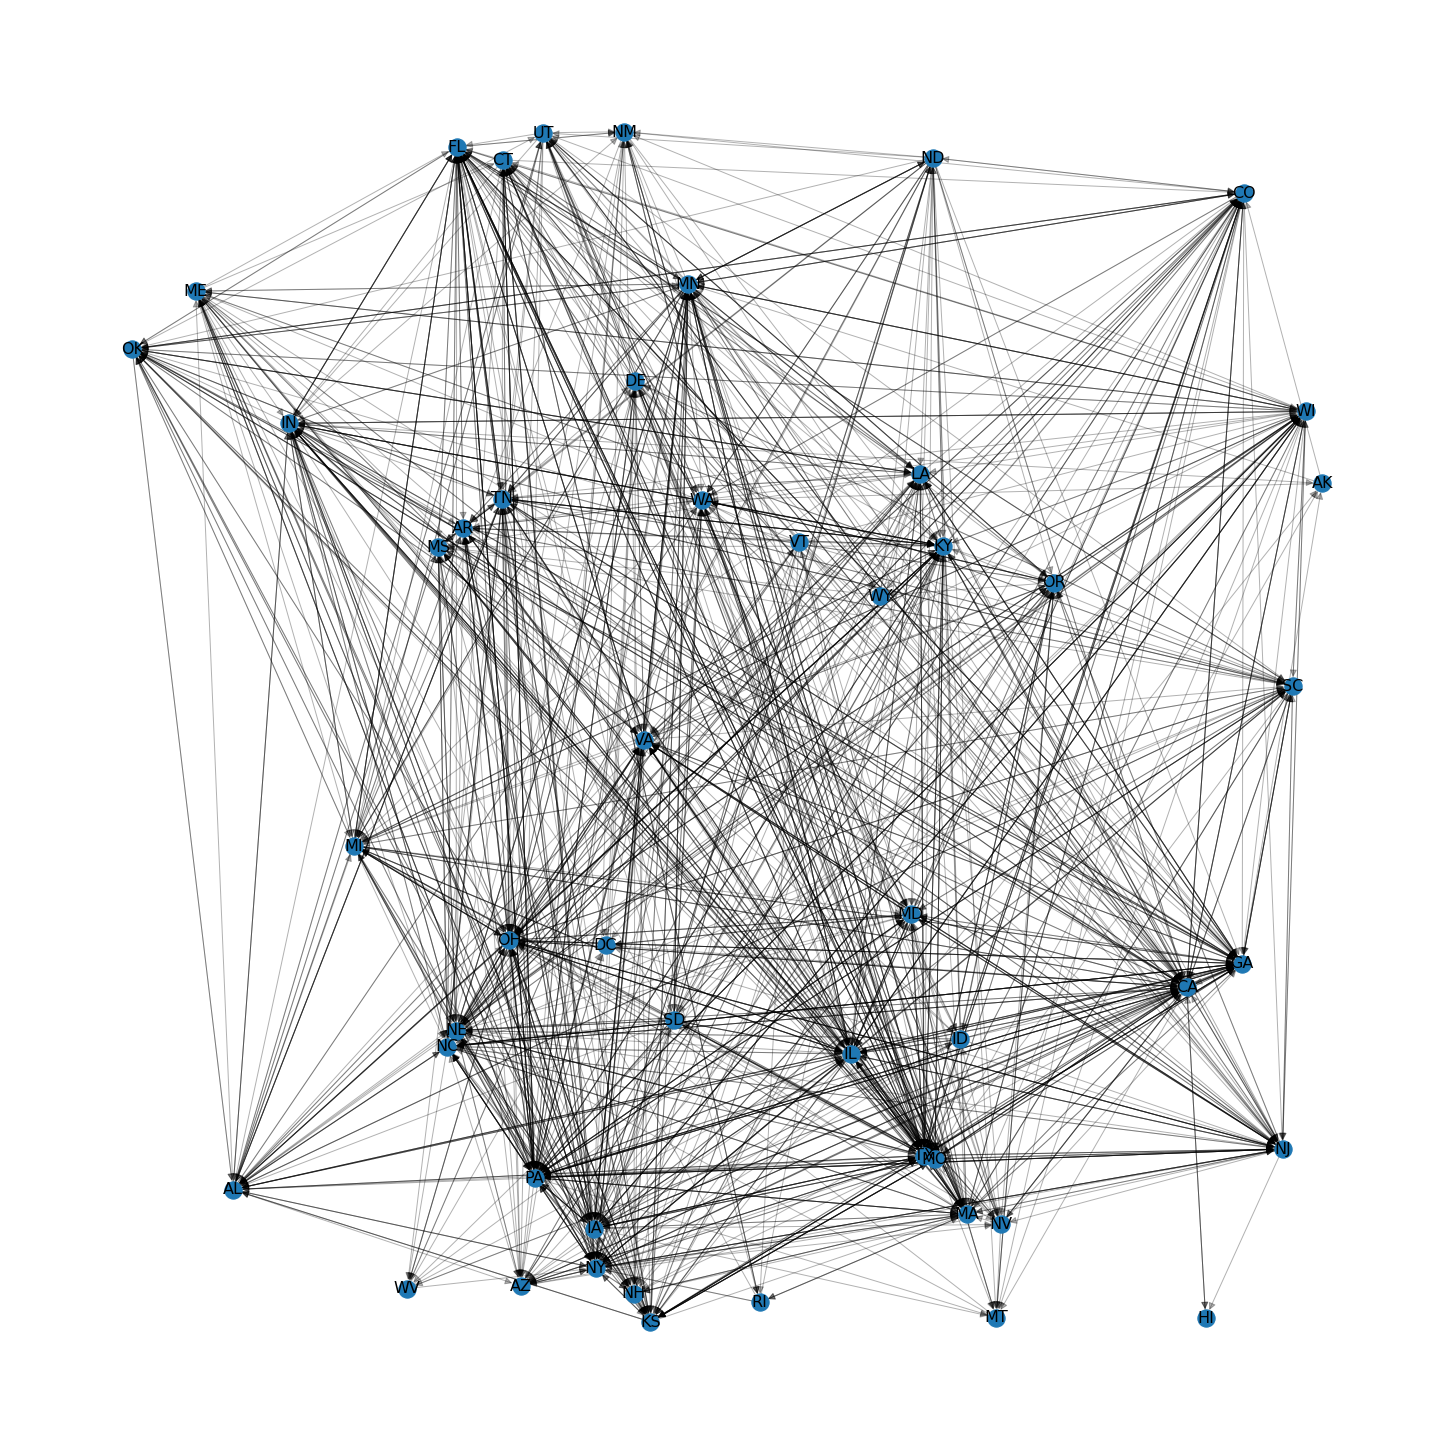

In [20]:
# Visualization for 2012 state-level data
plt.figure(figsize=(20,20)) 
nx.draw_random(state_2012_G, with_labels=True, node_size=300, font_size=16, edge_color=(0,0,0,0.3), arrowsize=15)
plt.show()

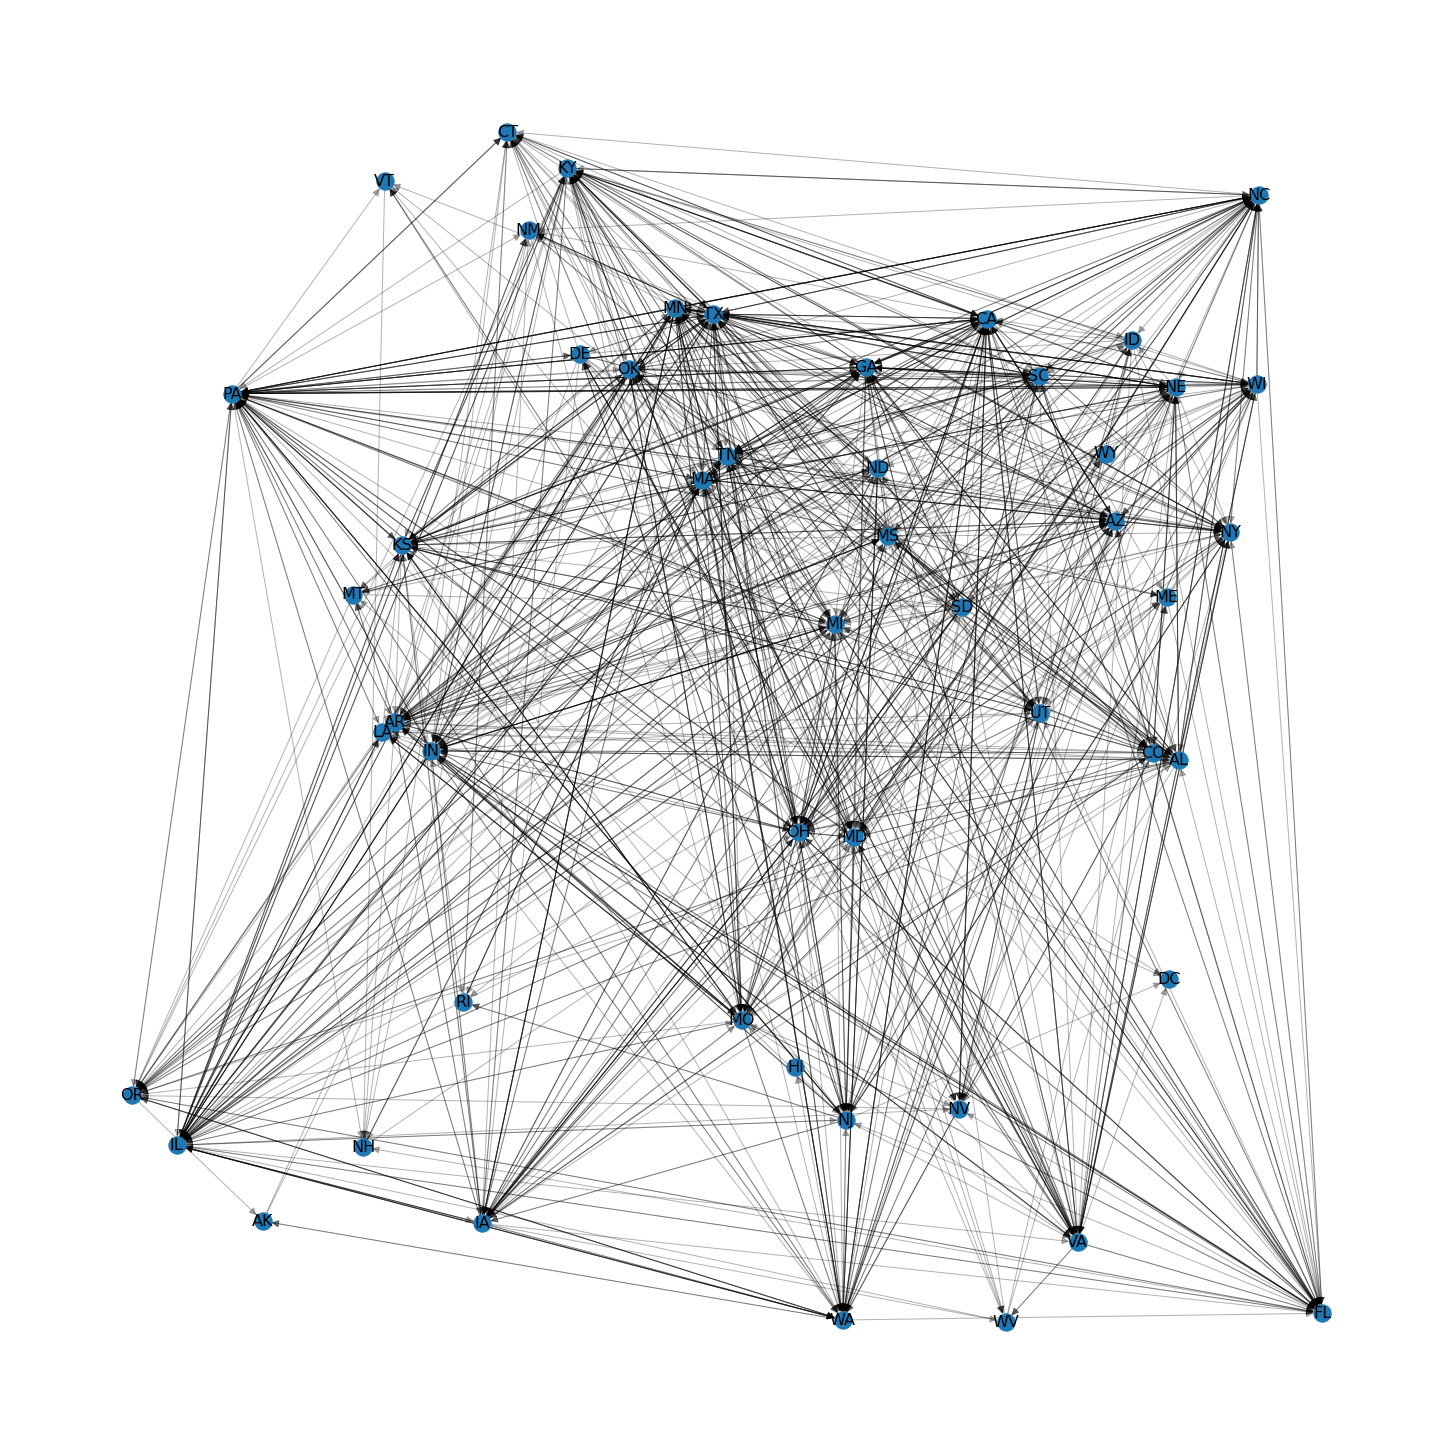

In [21]:
# Visualization for 2017 state-level data
plt.figure(figsize=(20,20)) 
nx.draw_random(state_2017_G, with_labels=True, node_size=300, font_size=16, edge_color=(0,0,0,0.3), arrowsize=15)
plt.show()

### node-level and network-level resilience computation
The algorithm follows Section 2.2 in the paper.

In [22]:
def calculate_node_resilience(edges, comm_level_dict, adjacency_dict, alpha=1.0, beta=0.9, level='state'):
    comm_stat_dict = {'comm_ttl': {},
                      'l1_1_val_s': 0.0,
                      'l1_2_val_s': 0.0,
                      'l1_val_s': 0.0,
                     }

    for e in edges:
        origin, destination, edge_data = e
        # initialize stat dict for specific comm_ttl
        if edge_data['COMM_TTL'] not in comm_stat_dict['comm_ttl']:
            comm_stat_dict['comm_ttl'][edge_data['COMM_TTL']] = {}
            comm_stat_dict['comm_ttl'][edge_data['COMM_TTL']]['VAL'] = []
        if level=='state': # for state-level data, we use state adjacency (unfixed beta)
            VAL_calibrated = edge_data['VAL'] * (1.0 if edge_data['AVGMILE'] < alpha else edge_data['AVGMILE']**0.5) * (beta if origin in adjacency_dict[destination] else 1.0)
        else: # for region-level and division-level data, we do not use adjacency (fixed beta)
            VAL_calibrated = edge_data['VAL'] * (1.0 if edge_data['AVGMILE'] < alpha else edge_data['AVGMILE']**0.5) * beta
        comm_stat_dict['comm_ttl'][edge_data['COMM_TTL']]['VAL'].append(VAL_calibrated)
        if edge_data['COMM_TTL'] in agri_comm_level_dict['l1_1']:
            comm_stat_dict['l1_1_val_s'] += VAL_calibrated
        if edge_data['COMM_TTL'] in agri_comm_level_dict['l1_2']:
            comm_stat_dict['l1_2_val_s'] += VAL_calibrated

    comm_stat_dict['l1_val_s'] = comm_stat_dict['l1_1_val_s'] + comm_stat_dict['l1_2_val_s']
    
    # calculate dependency risk for level 1, set l1_1
    for comm_ttl in agri_comm_level_dict['l1_1']:
        if 'l1_1_sum_weighted_dependency_risk' not in comm_stat_dict:
            comm_stat_dict['l1_1_sum_weighted_dependency_risk'] = 0.
        if 'l1_1_sum_dependency_risk' not in comm_stat_dict:
            comm_stat_dict['l1_1_sum_dependency_risk'] = 0.
        if comm_ttl not in comm_stat_dict['comm_ttl']:
            continue
        v_sum = np.sum(comm_stat_dict['comm_ttl'][comm_ttl]['VAL'])
        comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk'] = np.prod([(v/v_sum)**(v/v_sum) for v in comm_stat_dict['comm_ttl'][comm_ttl]['VAL']])
        comm_stat_dict['l1_1_sum_dependency_risk'] += comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk']
        comm_stat_dict['comm_ttl'][comm_ttl]['weighted_dependency_risk'] = comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk'] * v_sum
        comm_stat_dict['l1_1_sum_weighted_dependency_risk'] += comm_stat_dict['comm_ttl'][comm_ttl]['weighted_dependency_risk']
    
    # calculate dependency risk for level 1, set l1_2
    for comm_ttl in agri_comm_level_dict['l1_2']:
        if 'l1_2_sum_weighted_dependency_risk' not in comm_stat_dict:
            comm_stat_dict['l1_2_sum_weighted_dependency_risk'] = 0.
        if 'l1_2_sum_dependency_risk' not in comm_stat_dict:
            comm_stat_dict['l1_2_sum_dependency_risk'] = 0.
        if comm_ttl not in comm_stat_dict['comm_ttl']:
            continue
        v_sum = np.sum(comm_stat_dict['comm_ttl'][comm_ttl]['VAL'])
        comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk'] = np.prod([(v/v_sum)**(v/v_sum) for v in comm_stat_dict['comm_ttl'][comm_ttl]['VAL']])
        comm_stat_dict['l1_2_sum_dependency_risk'] += comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk']
        comm_stat_dict['comm_ttl'][comm_ttl]['weighted_dependency_risk'] = comm_stat_dict['comm_ttl'][comm_ttl]['dependency_risk'] * v_sum
        comm_stat_dict['l1_2_sum_weighted_dependency_risk'] += comm_stat_dict['comm_ttl'][comm_ttl]['weighted_dependency_risk']
        
    comm_stat_dict['l1_1_dependency_risk'] = np.prod([(comm_stat_dict['comm_ttl'][l1_1_comm]['weighted_dependency_risk'] /
                                                       comm_stat_dict['l1_1_sum_weighted_dependency_risk'])**
                                                      (comm_stat_dict['comm_ttl'][l1_1_comm]['weighted_dependency_risk'] /
                                                       comm_stat_dict['l1_1_sum_weighted_dependency_risk']) \
                                                      for l1_1_comm in agri_comm_level_dict['l1_1'] \
                                                      if l1_1_comm in comm_stat_dict['comm_ttl']])
    
    comm_stat_dict['l1_2_dependency_risk'] = np.prod([(comm_stat_dict['comm_ttl'][l1_2_comm]['weighted_dependency_risk'] /
                                                       comm_stat_dict['l1_2_sum_weighted_dependency_risk'])**
                                                      (comm_stat_dict['comm_ttl'][l1_2_comm]['weighted_dependency_risk'] /
                                                       comm_stat_dict['l1_2_sum_weighted_dependency_risk']) \
                                                      for l1_2_comm in agri_comm_level_dict['l1_2'] \
                                                      if l1_2_comm in comm_stat_dict['comm_ttl']])
    
    # weighting
    comm_stat_dict['l1_1_abs_dependency_risk'] = comm_stat_dict['l1_1_dependency_risk'] * comm_stat_dict['l1_1_sum_weighted_dependency_risk']
    comm_stat_dict['l1_2_abs_dependency_risk'] = comm_stat_dict['l1_2_dependency_risk'] * comm_stat_dict['l1_2_sum_weighted_dependency_risk']
    
    # normalization
    comm_stat_dict['l1_1_norm_abs_dependency_risk'] = comm_stat_dict['l1_1_abs_dependency_risk'] / (comm_stat_dict['l1_1_abs_dependency_risk'] + comm_stat_dict['l1_2_abs_dependency_risk'])
    comm_stat_dict['l1_2_norm_abs_dependency_risk'] = comm_stat_dict['l1_2_abs_dependency_risk'] / (comm_stat_dict['l1_1_abs_dependency_risk'] + comm_stat_dict['l1_2_abs_dependency_risk']) 
    
    # dependence risk for level 1
    comm_stat_dict['l1_dependency_risk'] = np.prod([comm_stat_dict['l1_1_norm_abs_dependency_risk']**comm_stat_dict['l1_1_norm_abs_dependency_risk'],
                                               comm_stat_dict['l1_2_norm_abs_dependency_risk']**comm_stat_dict['l1_2_norm_abs_dependency_risk']])
    
    # node resilience
    comm_stat_dict['node_resilience'] = 1 - comm_stat_dict['l1_dependency_risk'] * (comm_stat_dict['l1_1_abs_dependency_risk'] + comm_stat_dict['l1_2_abs_dependency_risk']) / comm_stat_dict['l1_val_s']
    
    return comm_stat_dict

In [23]:
def get_resilience_df(G, agri_comm_level_dict, adjacency_dict, alpha=1.0, beta=0.9, level='state'):
    node_list = []
    node_import_resilience_list = []
    node_export_resilience_list = []
    node_import_impact_to_network_list = []
    node_export_impact_to_network_list = []

    node_import_res_list = []
    node_export_res_list = []

    for node in tqdm(G.nodes):
        node_list.append(node)
        import_res = calculate_node_resilience(G.in_edges(node, data=True), agri_comm_level_dict, adjacency_dict, alpha, beta, level)
        export_res = calculate_node_resilience(G.out_edges(node, data=True), agri_comm_level_dict, adjacency_dict, alpha, beta, level)
        node_import_resilience_list.append(import_res['node_resilience'])
        node_export_resilience_list.append(export_res['node_resilience'])
        node_import_impact_to_network_list.append(import_res['node_resilience'] * import_res['l1_val_s'])
        node_export_impact_to_network_list.append(export_res['node_resilience'] * export_res['l1_val_s'])
        node_import_res_list.append(import_res)
        node_export_res_list.append(export_res)

    node_import_resilience_network_list = [impact/np.sum(node_import_impact_to_network_list) for impact in node_import_impact_to_network_list]
    node_export_resilience_network_list = [impact/np.sum(node_export_impact_to_network_list) for impact in node_export_impact_to_network_list]

    node_resilience_df = pd.DataFrame()
    node_resilience_df['node'] = node_list
    node_resilience_df['import_resilience'] = node_import_resilience_list
    node_resilience_df['export_resilience'] = node_export_resilience_list
    node_resilience_df['import_impact_to_network'] = node_import_impact_to_network_list
    node_resilience_df['export_impact_to_network'] = node_export_impact_to_network_list
    node_resilience_df['import_resilience_network'] = node_import_resilience_network_list
    node_resilience_df['export_resilience_network'] = node_export_resilience_network_list
    return node_resilience_df

In [24]:
# for state-level data, we use state adjacency
state_2012_res_df = get_resilience_df(state_2012_G, agri_comm_level_dict, state_adjacency_dict, alpha=1.0, beta=0.9, level='state')
state_2017_res_df = get_resilience_df(state_2017_G, agri_comm_level_dict, state_adjacency_dict, alpha=1.0, beta=0.9, level='state')

# for region-level and division-level data, we do not use adjacency
division_2012_res_df = get_resilience_df(division_2012_G, agri_comm_level_dict, None, alpha=1.0, beta=0.9, level='division')
division_2017_res_df = get_resilience_df(division_2017_G, agri_comm_level_dict, None, alpha=1.0, beta=0.9, level='division')
region_2012_res_df = get_resilience_df(region_2012_G, agri_comm_level_dict, None, alpha=1.0, beta=0.9, level='region')
region_2017_res_df = get_resilience_df(region_2017_G, agri_comm_level_dict, None, alpha=1.0, beta=0.9, level='region')

100%|██████████| 4/4 [00:00<00:00, 3661.55it/s]


In [25]:
state_2012_res_df.head(10)

node  import_resilience  export_resilience  import_impact_to_network  \
0   AL           0.923772           0.912361              72347.953568   
1   AZ           0.928123           0.823752              86040.049861   
2   AR           0.819417           0.803093             113942.744707   
3   CO           0.919641           0.954347             122281.432717   
4   GA           0.971603           0.968234             375777.102379   
5   IL           0.962068           0.952735             583182.386183   
6   IN           0.941584           0.968956             164911.014965   
7   KY           0.945392           0.962133              87503.102672   
8   LA           0.946856           0.882507             314855.198022   
9   ME           0.868562           0.893905              16549.083097   

   export_impact_to_network  import_resilience_network  \
0              82272.716650                   0.008699   
1              49127.415453                   0.010345   
2             111213.081196                   0.013701   
3             118516.632954                   0.014703   
4             294914.049063                   0.045184   
5             505235.175394                   0.070122   
6             265462.668542                   0.019829   
7             138063.409297                   0.010521   
8              65474.935617                   0.037858   
9              25213.655635                   0.001990   

   export_resilience_network  
0                   0.009883  
1                   0.005902  
2                   0.013360  
3                   0.014237  
4                   0.035427  
5                   0.060693  
6                   0.031889  
7                   0.016585  
8                   0.007865  
9                   0.003029

### overall network-level resilience in 2012 and 2017 at different geographical scales (Table 5 in the paper)

In [26]:
state_2012_network_resilience = 1 - (state_2012_res_df['import_resilience_network'].max() + state_2012_res_df['export_resilience_network'].max())/2
state_2017_network_resilience = 1 - (state_2017_res_df['import_resilience_network'].max() + state_2017_res_df['export_resilience_network'].max())/2

In [27]:
(state_2012_network_resilience, state_2017_network_resilience, (state_2017_network_resilience - state_2012_network_resilience)/state_2012_network_resilience)

(0.8672235222863846, 0.8799901308896602, 0.014721243457069967)

In [28]:
division_2012_network_resilience = 1 - (division_2012_res_df['import_resilience_network'].max() + division_2012_res_df['export_resilience_network'].max())/2
division_2017_network_resilience = 1 - (division_2017_res_df['import_resilience_network'].max() + division_2017_res_df['export_resilience_network'].max())/2

In [29]:
(division_2012_network_resilience, division_2017_network_resilience, (division_2017_network_resilience - division_2012_network_resilience)/division_2012_network_resilience)

(0.7658206348296364, 0.7625924285604158, -0.00421535555768714)

In [30]:
region_2012_network_resilience = 1 - (region_2012_res_df['import_resilience_network'].max() + region_2012_res_df['export_resilience_network'].max())/2
region_2017_network_resilience = 1 - (region_2017_res_df['import_resilience_network'].max() + region_2017_res_df['export_resilience_network'].max())/2

In [31]:
(region_2012_network_resilience, region_2017_network_resilience, (region_2017_network_resilience - region_2012_network_resilience)/region_2012_network_resilience)

(0.6474694079393777, 0.6043014544854985, -0.06667180398725639)